In [2]:
import os
from datetime import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
control_1 = pd.read_csv('C:/Users/User/Medical Datasets/depression/control/control_1.csv')
condition_1 = pd.read_csv('C:/Users/User/Medical Datasets/depression/condition/condition_1.csv')
print(f'control_1.shape: {control_1.shape}')
print(f'condition_1.shape: {condition_1.shape}')

control_1.shape: (51611, 3)
condition_1.shape: (23244, 3)


In [3]:
control_1.head()

timestamp        date  activity
0  2003-03-18 15:00:00  2003-03-18        60
1  2003-03-18 15:01:00  2003-03-18         0
2  2003-03-18 15:02:00  2003-03-18       264
3  2003-03-18 15:03:00  2003-03-18       662
4  2003-03-18 15:04:00  2003-03-18       293

In [4]:
condition_1.head()

timestamp        date  activity
0  2003-05-07 12:00:00  2003-05-07         0
1  2003-05-07 12:01:00  2003-05-07       143
2  2003-05-07 12:02:00  2003-05-07         0
3  2003-05-07 12:03:00  2003-05-07        20
4  2003-05-07 12:04:00  2003-05-07       166

In [5]:
condition_1.describe()

activity
count  23244.000000
mean     146.948030
std      294.592424
min        0.000000
25%        0.000000
50%        9.000000
75%      172.000000
max     3526.000000

<AxesSubplot:xlabel='activity', ylabel='Count'>

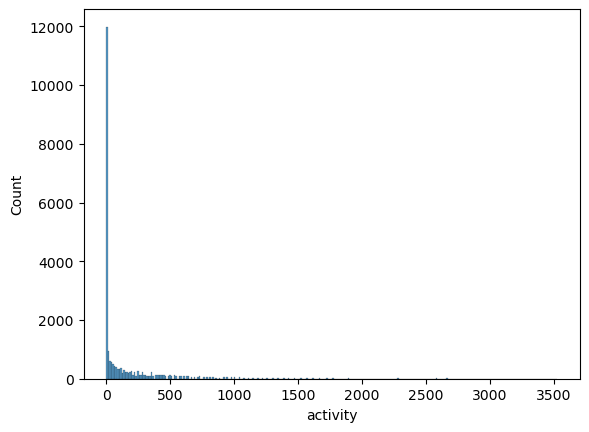

In [6]:
sns.histplot(x='activity', data=condition_1)

In [7]:
condition_1['log_activity'] = np.log(condition_1['activity'] + 1) # add + 1 because log(0) is infinity
condition_1['log_activity'].skew()

0.2771381485812395

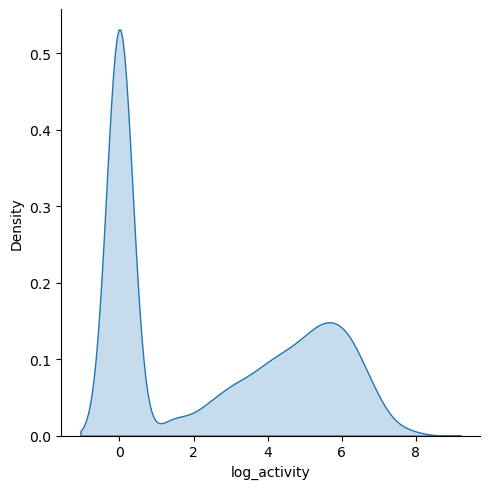

In [8]:
sns.displot(x='log_activity', data=condition_1, kind='kde', fill=True)

In [9]:
condition_1['sqrt_activity'] = np.sqrt(condition_1['activity'])
condition_1['sqrt_activity'].skew()

1.370447546298057

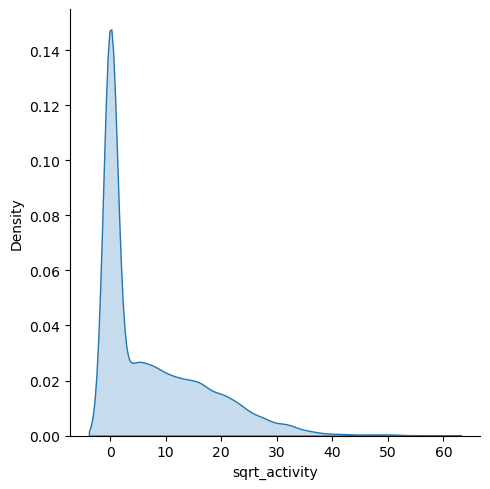

In [10]:
sns.displot(x='sqrt_activity', data=condition_1, kind='kde', fill=True)

In [11]:
condition_1.describe()

activity  log_activity  sqrt_activity
count  23244.000000  23244.000000   23244.000000
mean     146.948030      2.562035       7.416512
std      294.592424      2.626393       9.588917
min        0.000000      0.000000       0.000000
25%        0.000000      0.000000       0.000000
50%        9.000000      2.302585       3.000000
75%      172.000000      5.153292      13.114877
max     3526.000000      8.168203      59.380131

In [12]:
control_1['activity'].skew()

5.039169993104665

In [13]:
control_1.describe()

activity
count  51611.000000
mean      98.545078
std      289.655317
min        0.000000
25%        0.000000
50%        0.000000
75%        3.000000
max     6117.000000

In [14]:
control_1['log_activity'] = np.log(control_1['activity'] + 1)
control_1['log_activity'].skew()

1.2517081703386566

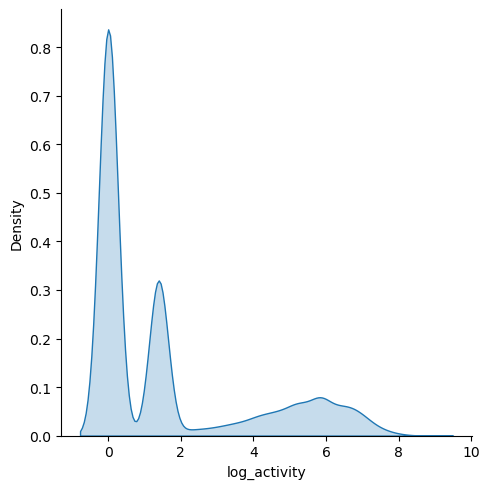

In [15]:
sns.displot(x='log_activity', data=control_1, kind='kde', fill=True)

In [16]:
condition_1.head()

timestamp        date  activity  log_activity  sqrt_activity
0  2003-05-07 12:00:00  2003-05-07         0      0.000000       0.000000
1  2003-05-07 12:01:00  2003-05-07       143      4.969813      11.958261
2  2003-05-07 12:02:00  2003-05-07         0      0.000000       0.000000
3  2003-05-07 12:03:00  2003-05-07        20      3.044522       4.472136
4  2003-05-07 12:04:00  2003-05-07       166      5.117994      12.884099

In [17]:
df = condition_1.groupby('date')['log_activity'].mean().reset_index()
df.head()

date  log_activity
0  2003-05-07      3.752204
1  2003-05-08      2.931977
2  2003-05-09      2.593095
3  2003-05-10      2.910573
4  2003-05-11      2.561446

In [18]:
def combine_data(path):
    dirs = os.listdir(path)
    combine_df = []
    
    for filepath in dirs:
        source = filepath.split('.')[0]
        if filepath.endswith('.csv'):
            X = pd.read_csv(path + filepath, parse_dates=['timestamp'], index_col='timestamp')
            X['source'] = source
            combine_df.append(X)
        
    return combine_df



In [19]:
combine_df = combine_data('C:/Users/User/Medical Datasets/depression/condition/')

In [20]:
combine_df

[                           date  activity       source
 timestamp                                             
 2003-05-07 12:00:00  2003-05-07         0  condition_1
 2003-05-07 12:01:00  2003-05-07       143  condition_1
 2003-05-07 12:02:00  2003-05-07         0  condition_1
 2003-05-07 12:03:00  2003-05-07        20  condition_1
 2003-05-07 12:04:00  2003-05-07       166  condition_1
 ...                         ...       ...          ...
 2003-05-23 15:19:00  2003-05-23         0  condition_1
 2003-05-23 15:20:00  2003-05-23         0  condition_1
 2003-05-23 15:21:00  2003-05-23         0  condition_1
 2003-05-23 15:22:00  2003-05-23         0  condition_1
 2003-05-23 15:23:00  2003-05-23       533  condition_1
 
 [23244 rows x 3 columns],
                            date  activity        source
 timestamp                                              
 2004-08-31 09:00:00  2004-08-31        91  condition_10
 2004-08-31 09:01:00  2004-08-31         0  condition_10
 2004-08-31 09:

In [21]:
conditions = []
for condition in combine_df:
    condition_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    condition_df['mean_activity'] = condition.activity.resample('H').mean()
    condition_df['std_activity'] = condition.activity.resample('H').std()
    condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
    condition_df['source'] = condition.source
    conditions.append(condition_df)

In [22]:
combine_df = combine_data('C:/Users/User/Medical Datasets/depression/control/')

In [23]:
controls = []
for control in combine_df:
    control_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    control_df['mean_activity'] = control.activity.resample('H').mean()
    control_df['std_activity'] = control.activity.resample('H').std()
    control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
    control_df['source'] = control.source
    controls.append(control_df)

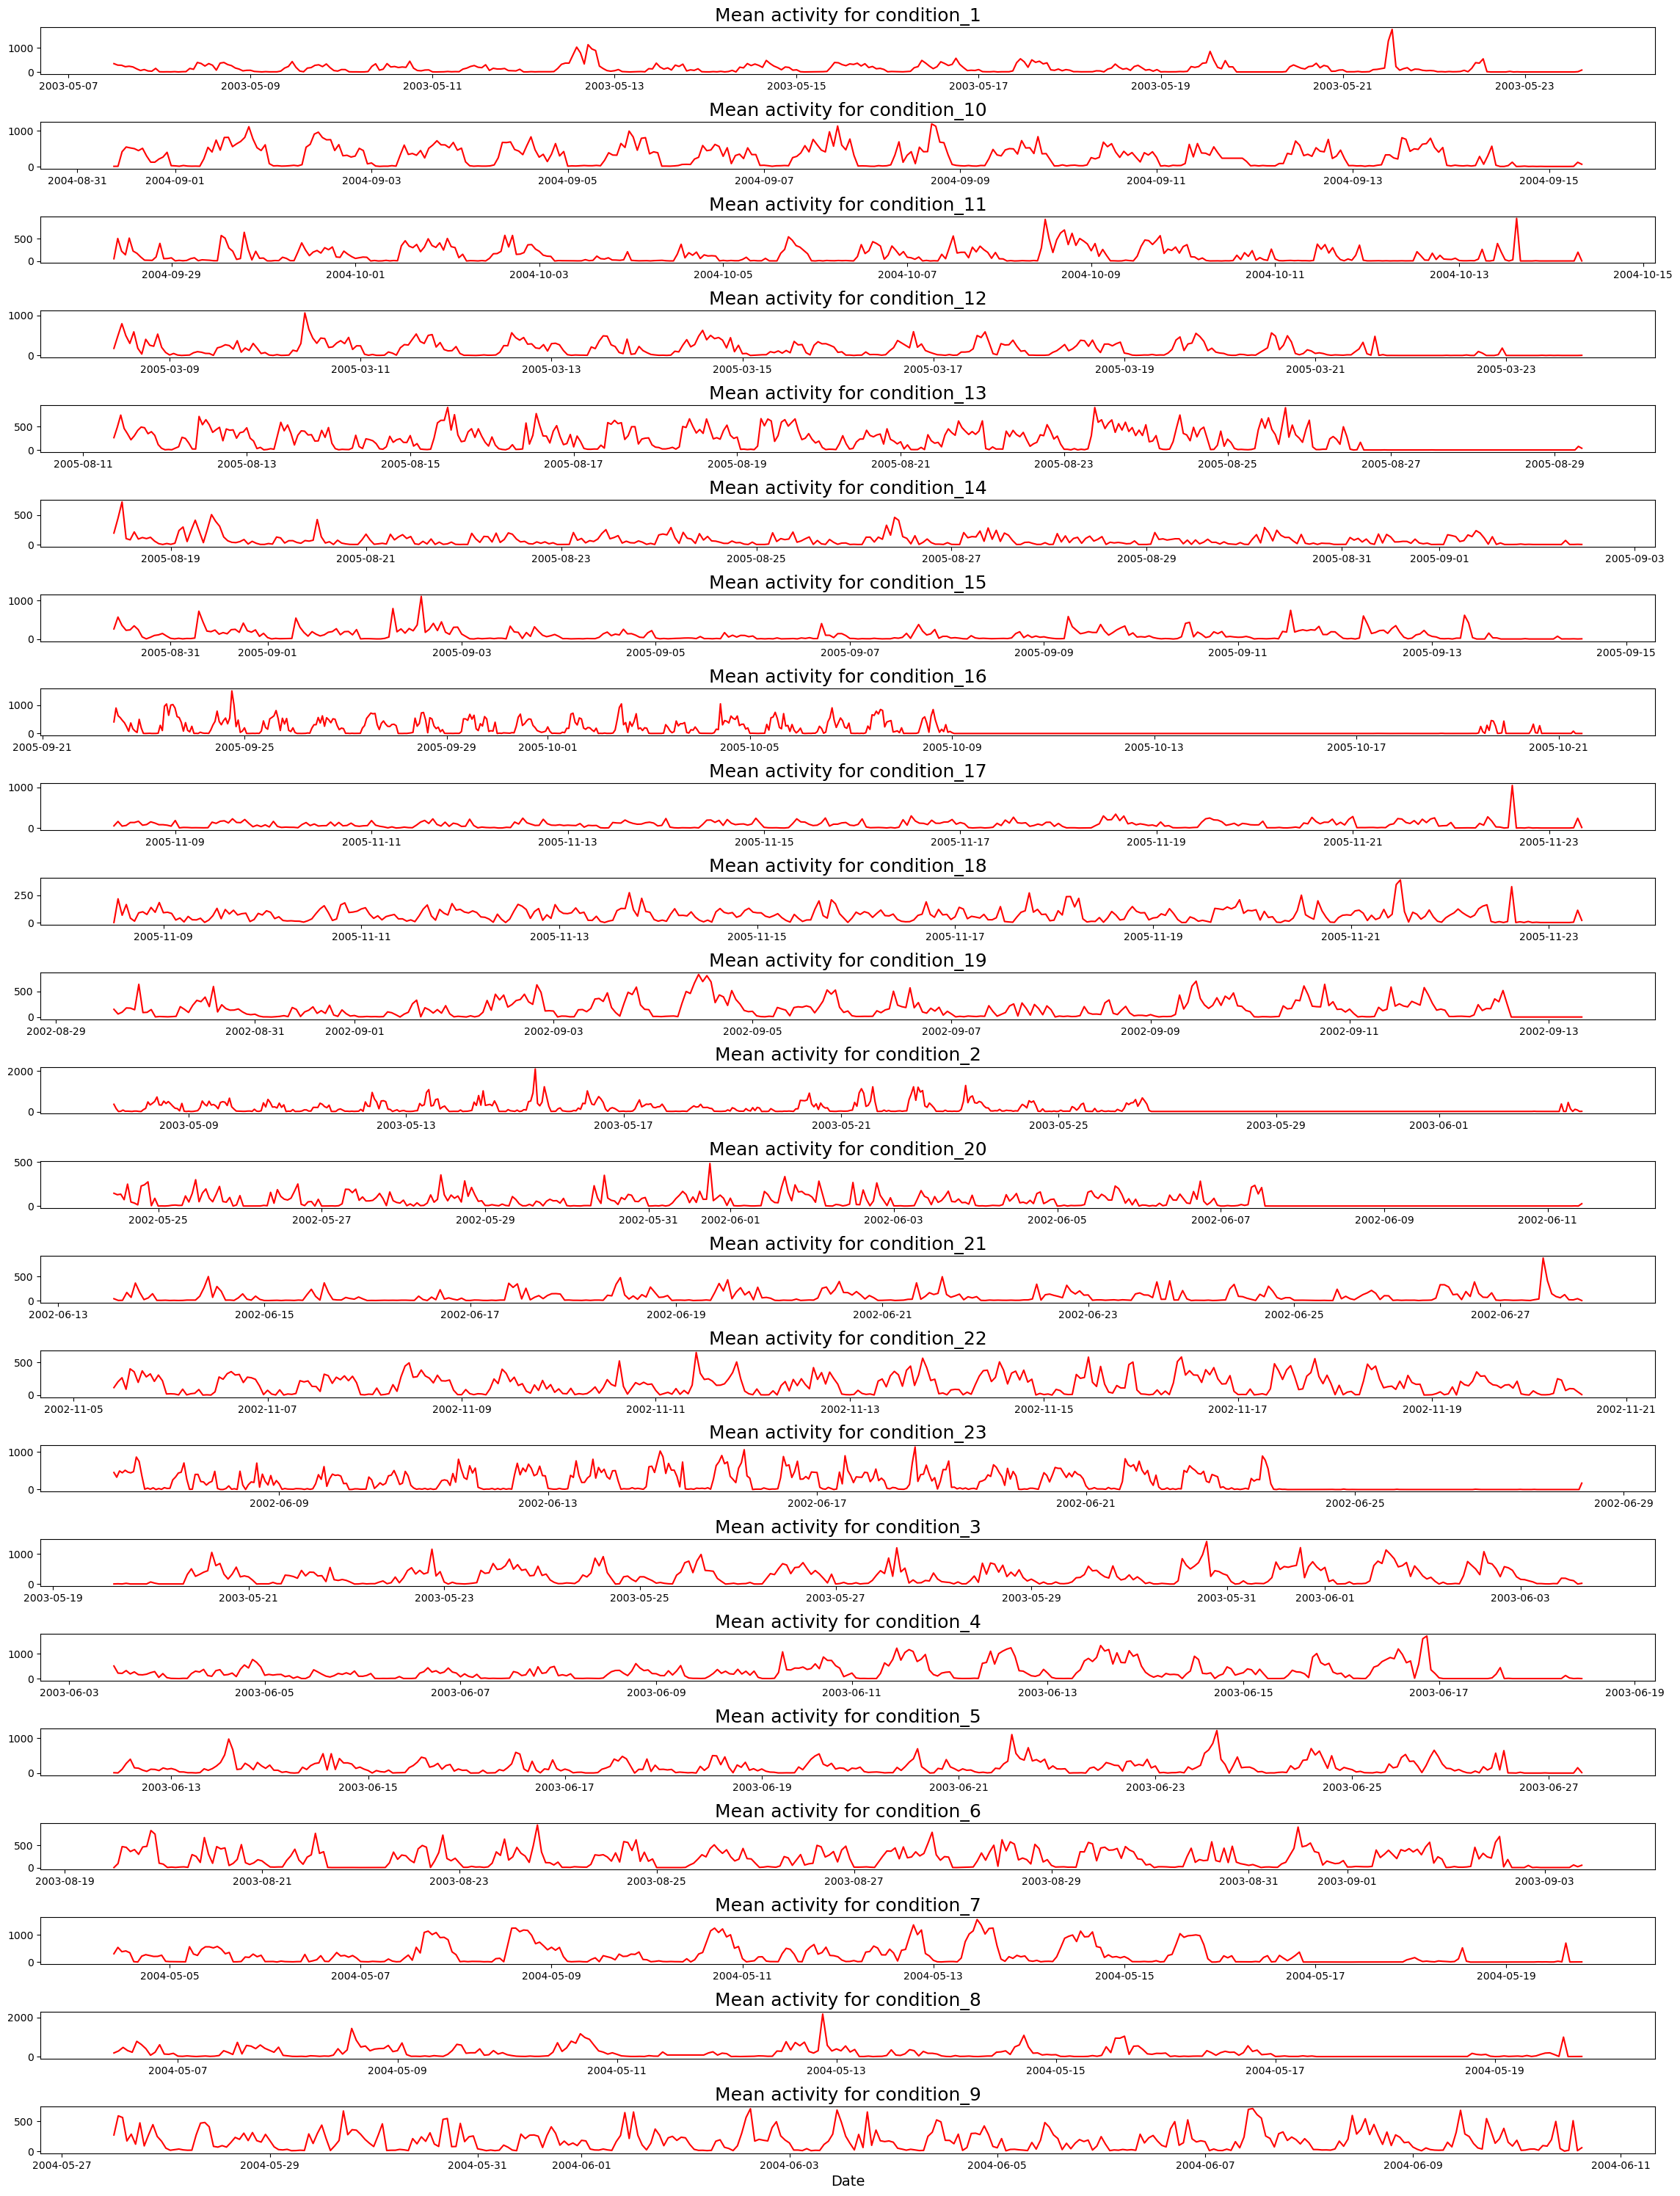

In [24]:
fig, axes = plt.subplots(23, 1, figsize=(23, 30))
cnt = 0
for i in range(23):
    condition = conditions[cnt]
    axes[i].plot(condition.index, condition.mean_activity, color='r')
    axes[i].set_title(f'Mean activity for {condition.source[1]}', fontsize=18)
    cnt += 1
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of condition group.jpg', dpi=100)
plt.show()

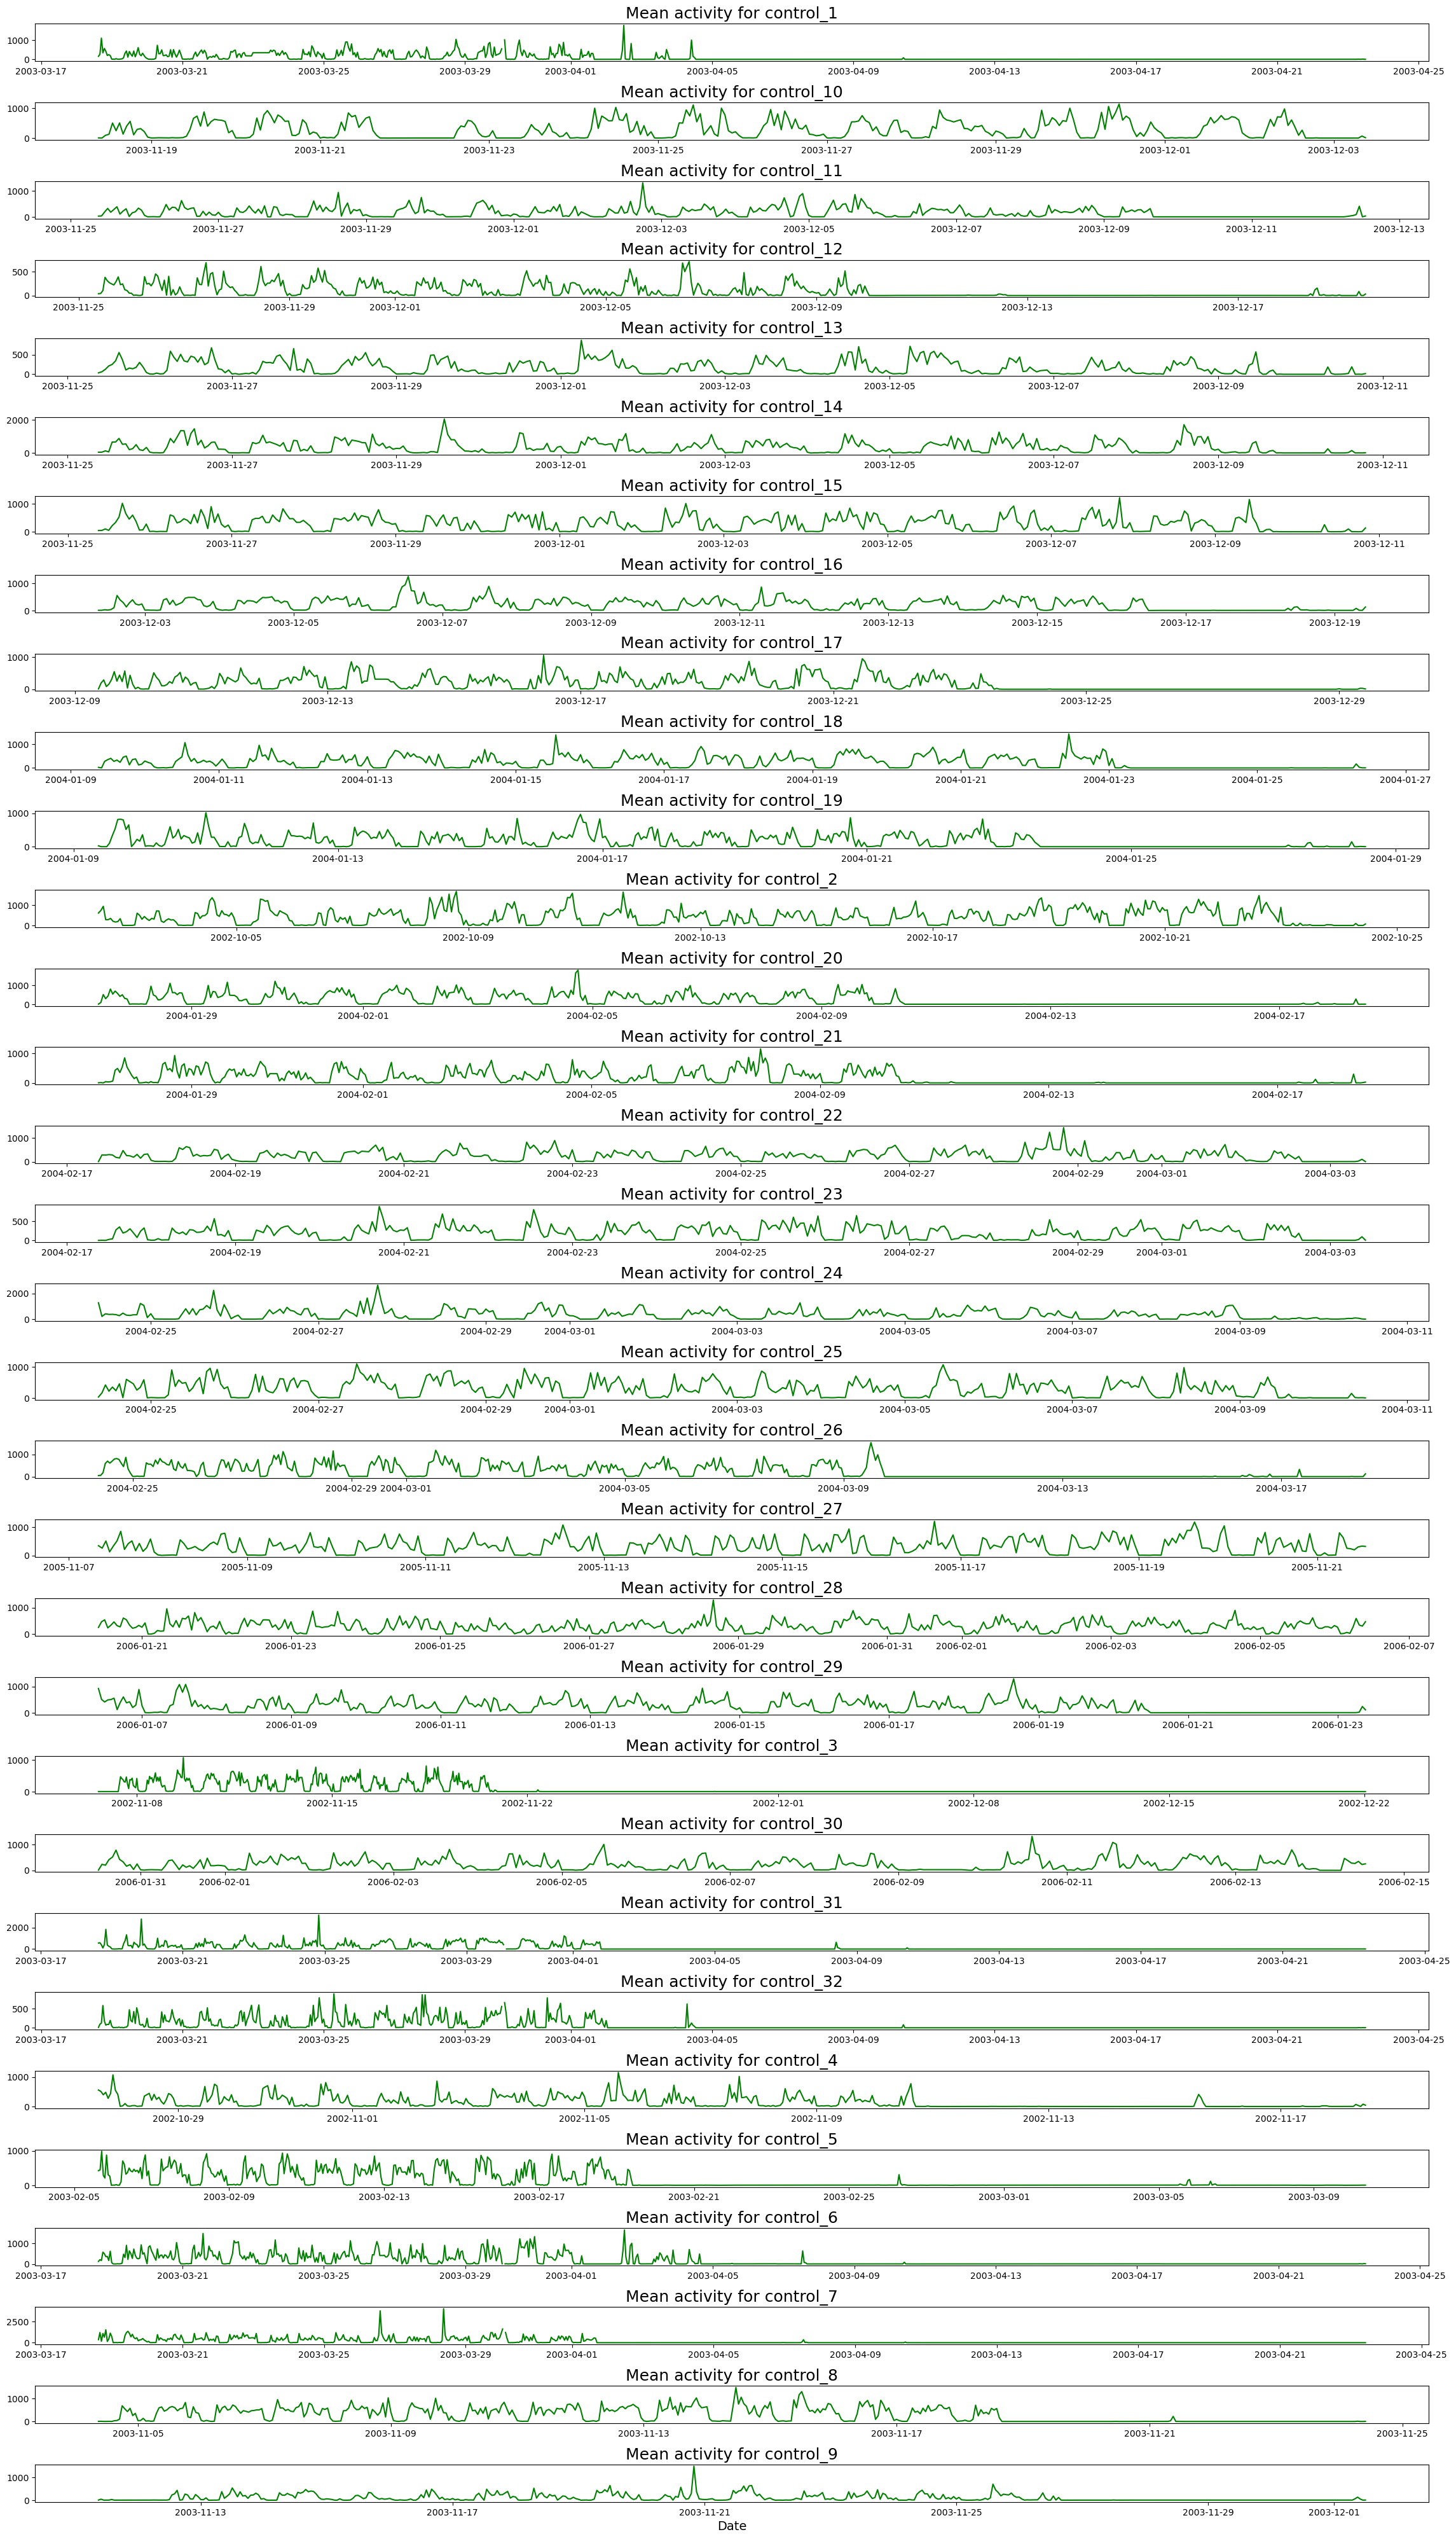

In [25]:
fig, axes = plt.subplots(32, 1, figsize=(23, 40))
cnt = 0
for i in range(32):
    control = controls[cnt]
    axes[i].plot(control.index, control.mean_activity, color='g')
    axes[i].set_title(f'Mean activity for {control.source[1]}', fontsize=18)
    cnt += 1
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of control group.jpg', dpi=100)
plt.show()

In [27]:
def to_clock(x):
    d = datetime.strptime(f'{x}:00', '%H:%M')
    return d.strftime('%I:%M %p')

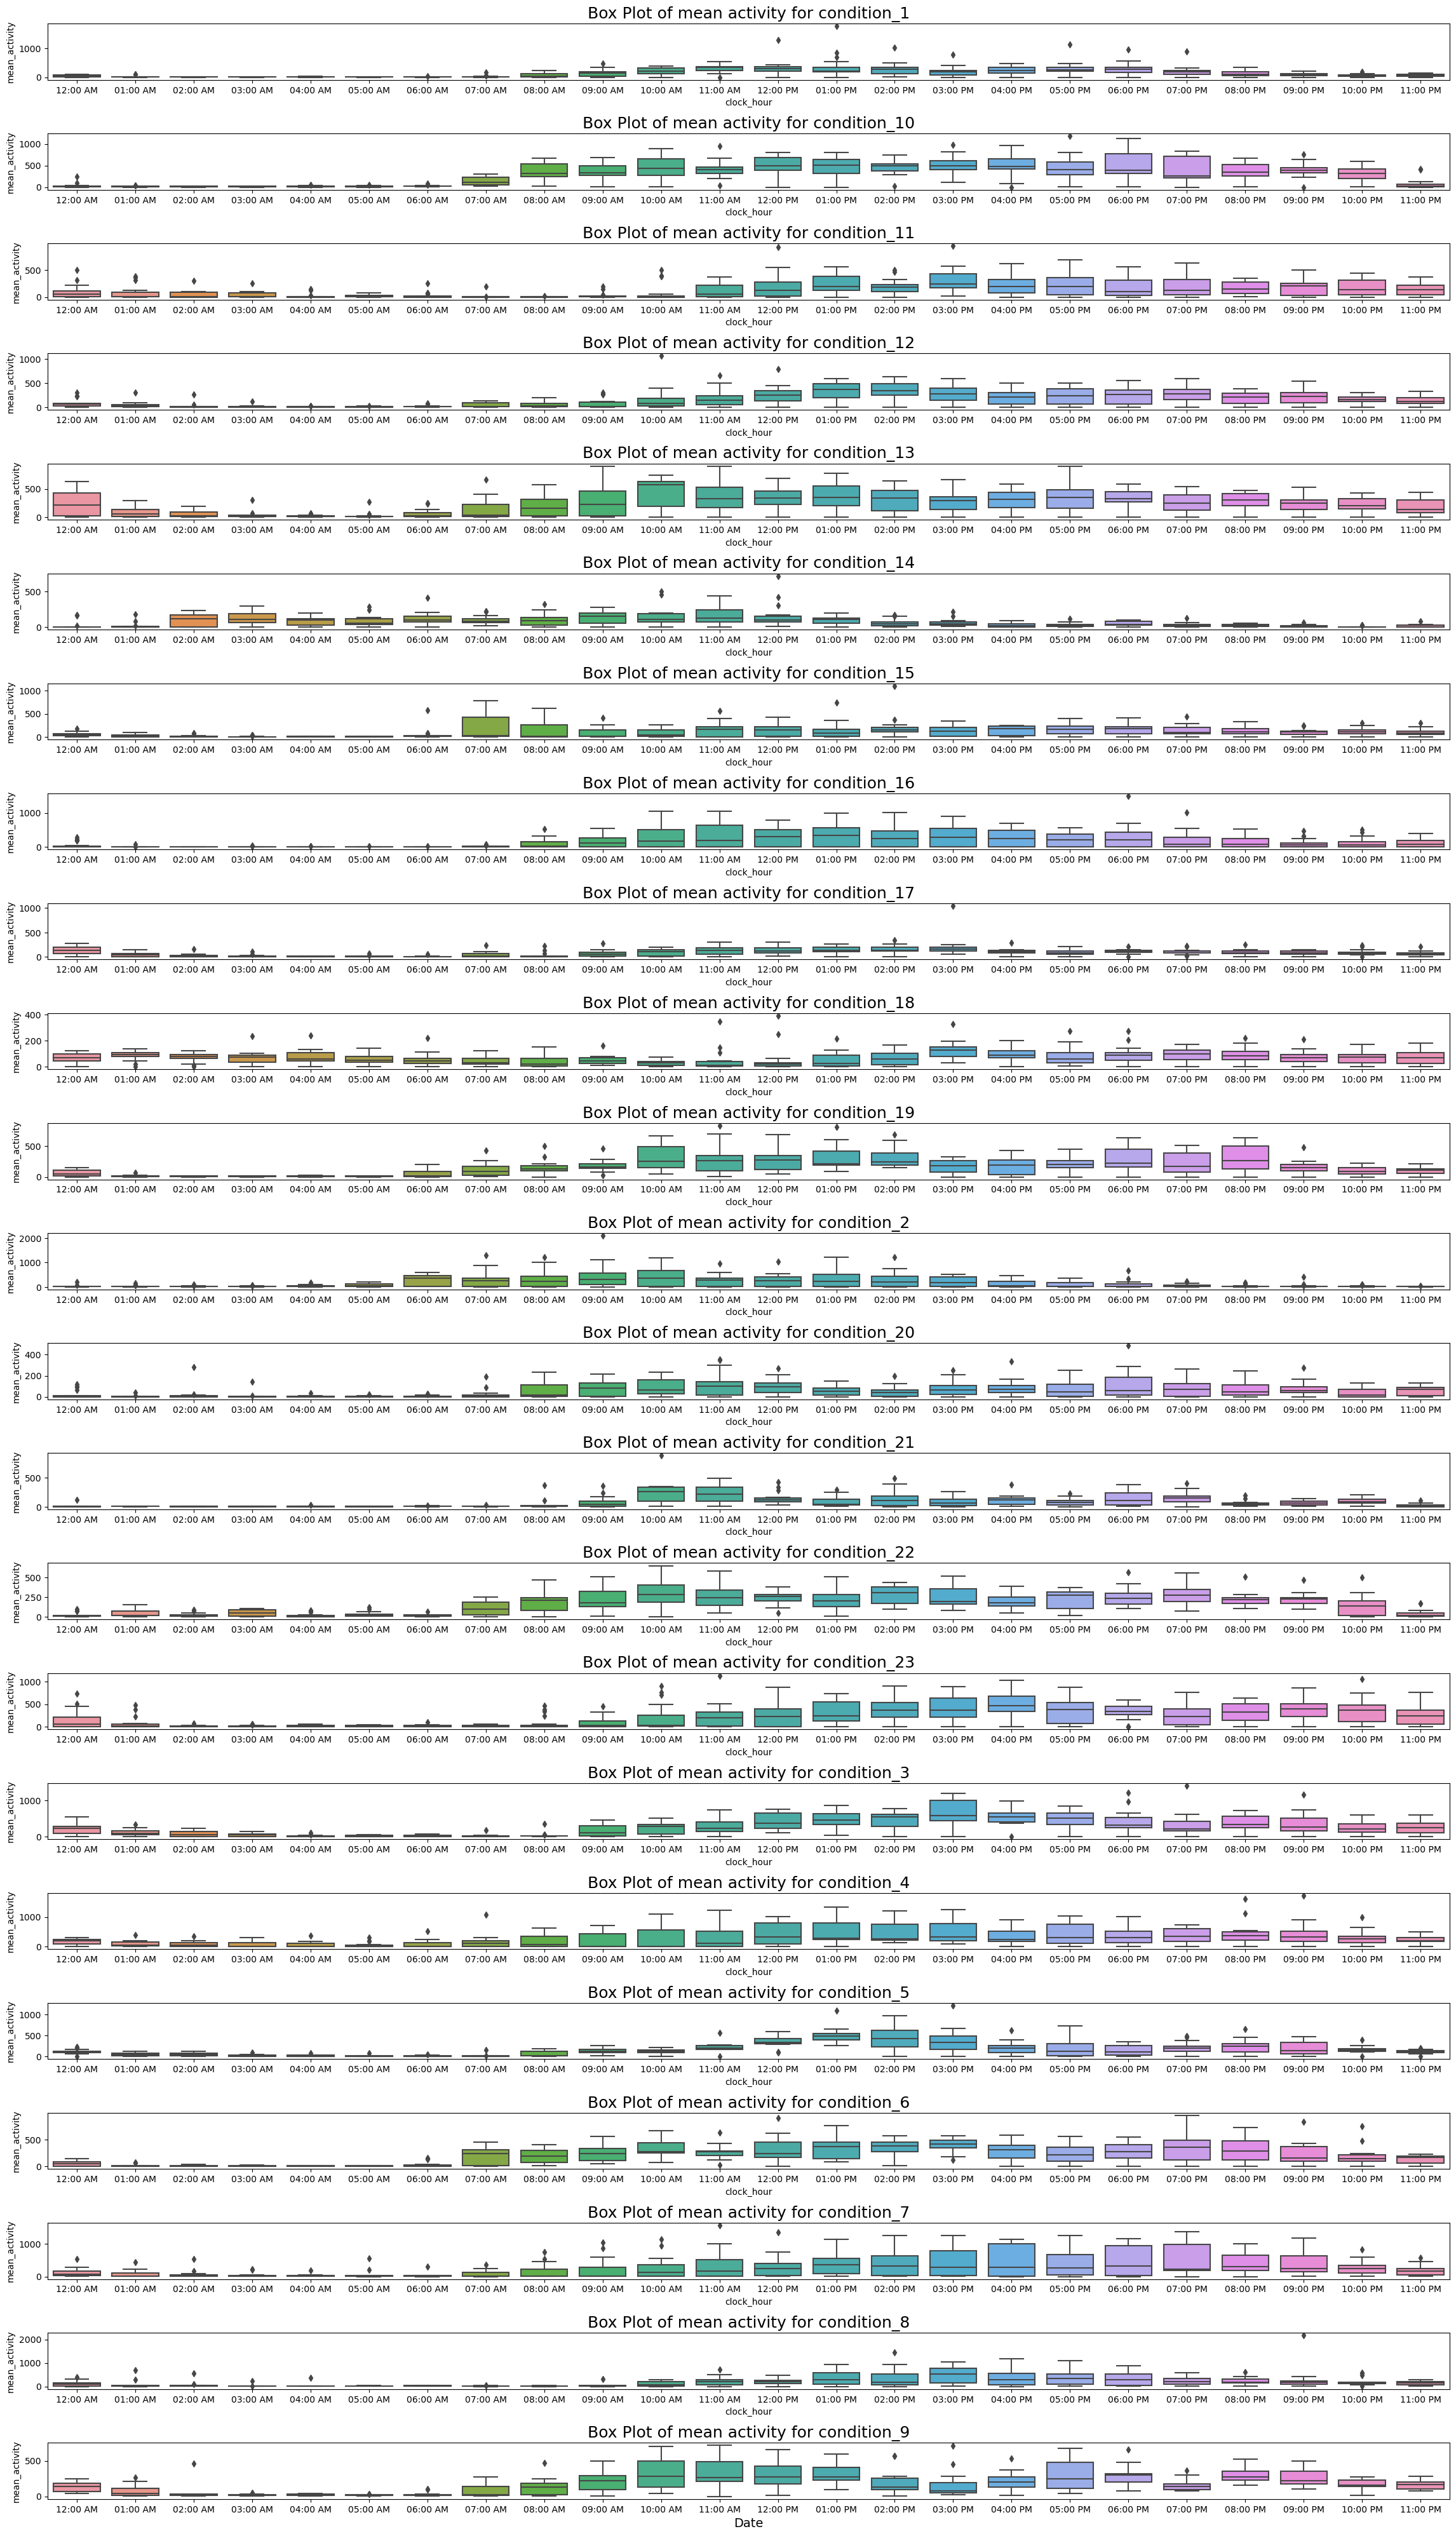

In [28]:
# Draw Plot
fig, axes = plt.subplots(23, 1, figsize=(23, 40))

cnt = 0
for i in range(23):
    df = conditions[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
plt.show()

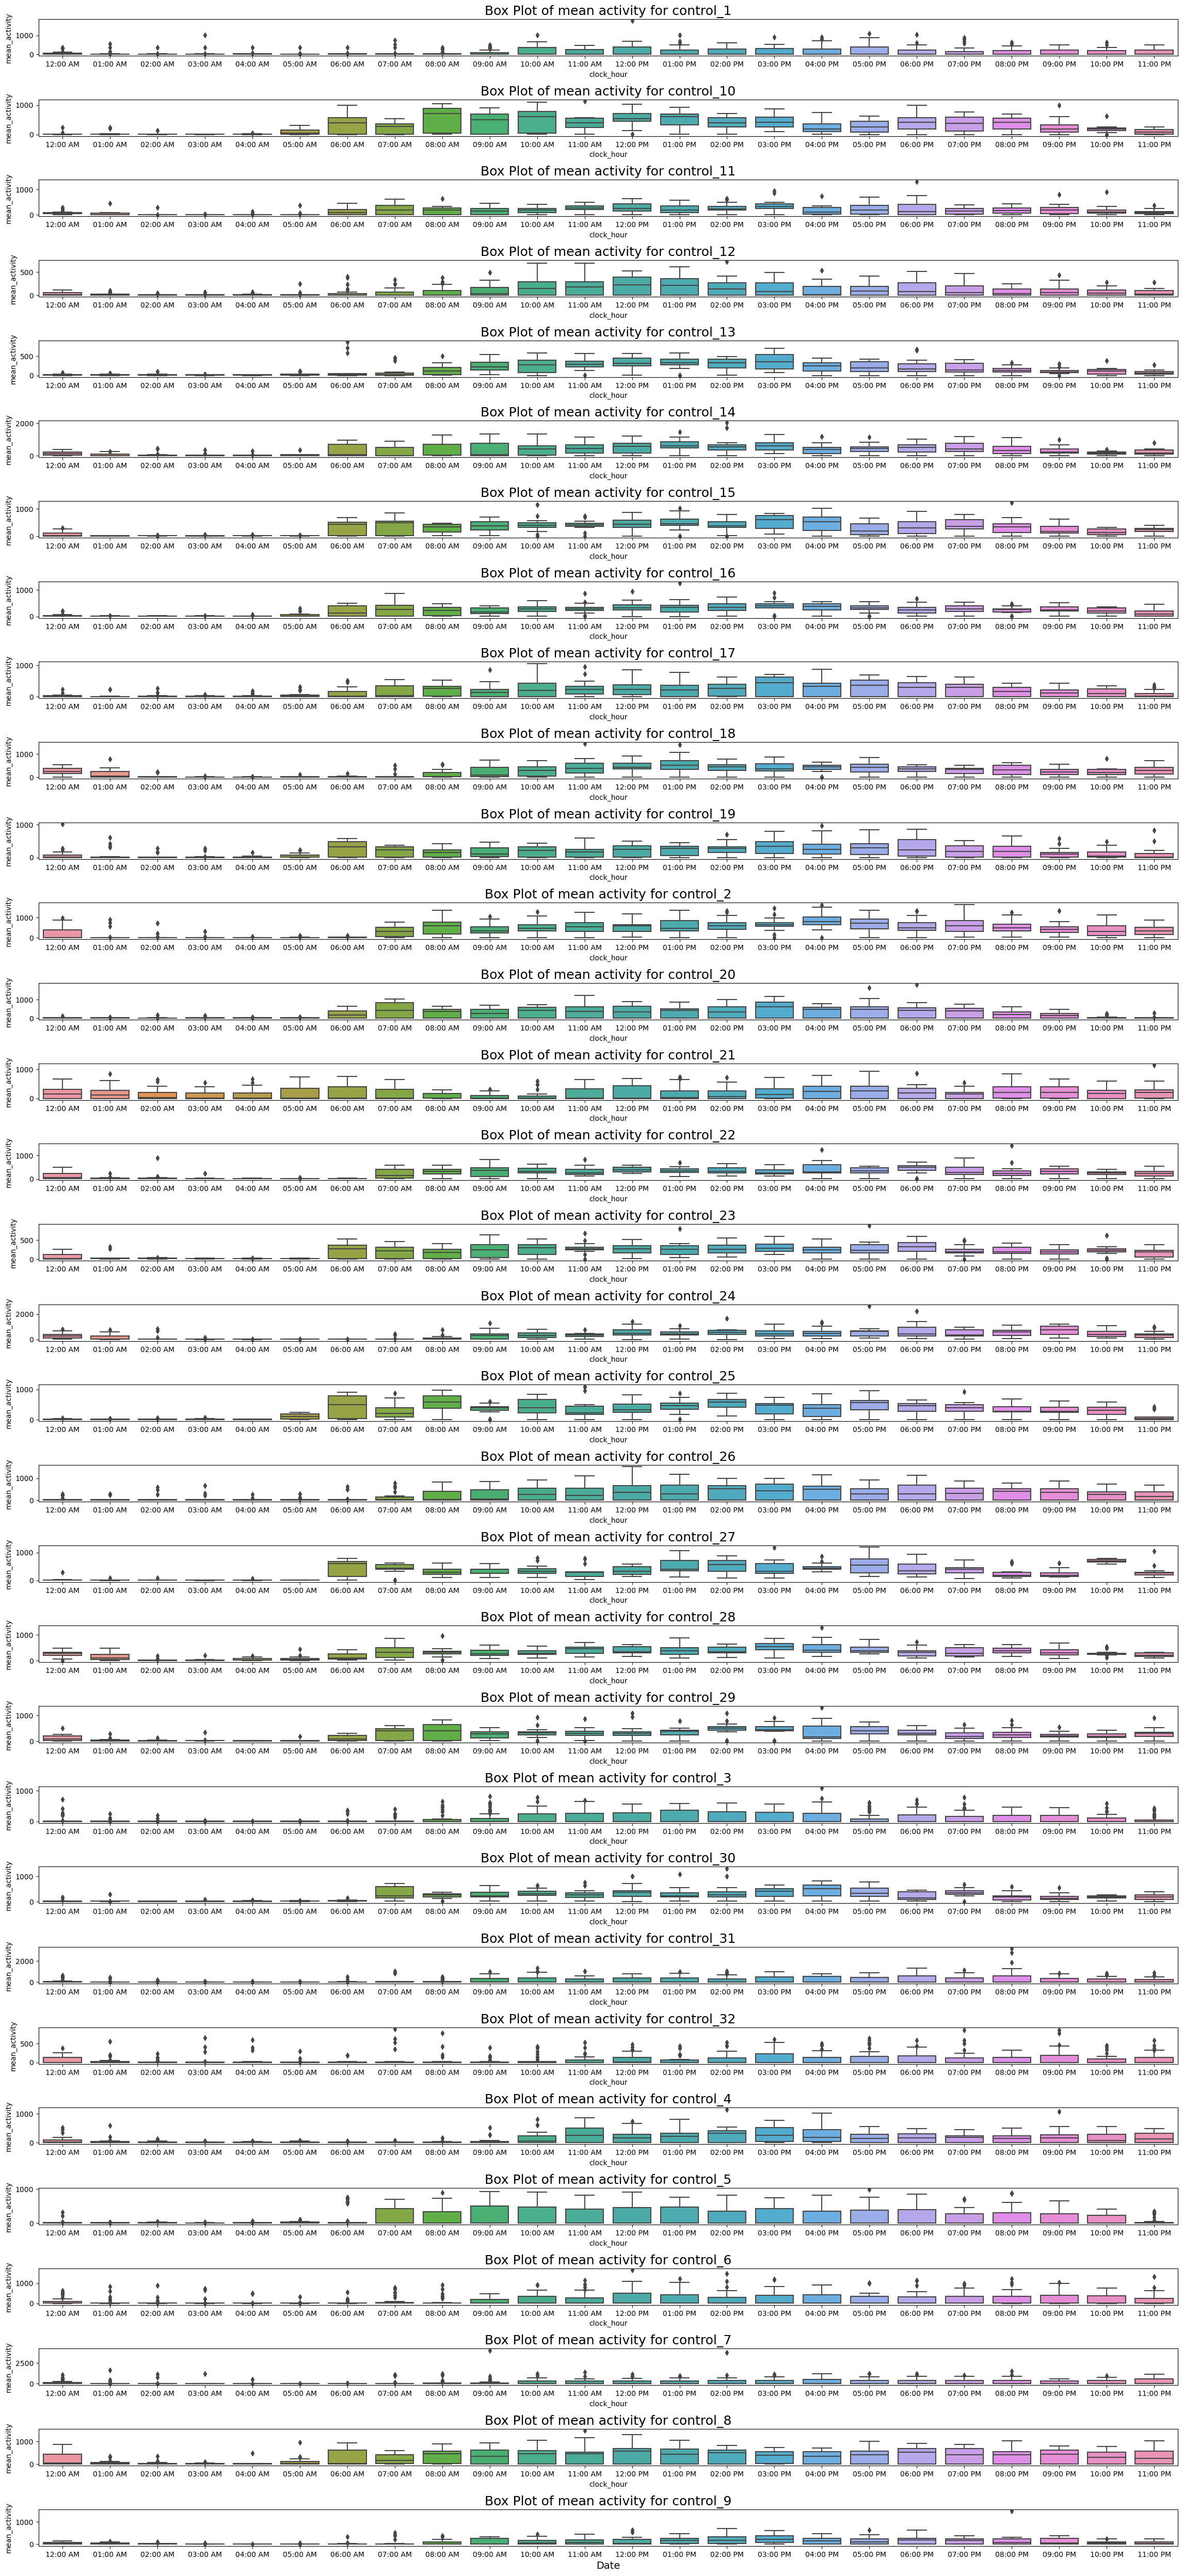

In [29]:
# Draw Plot
fig, axes = plt.subplots(32, 1, figsize=(23, 50))

cnt = 0
for i in range(32):
    df = controls[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
plt.show()

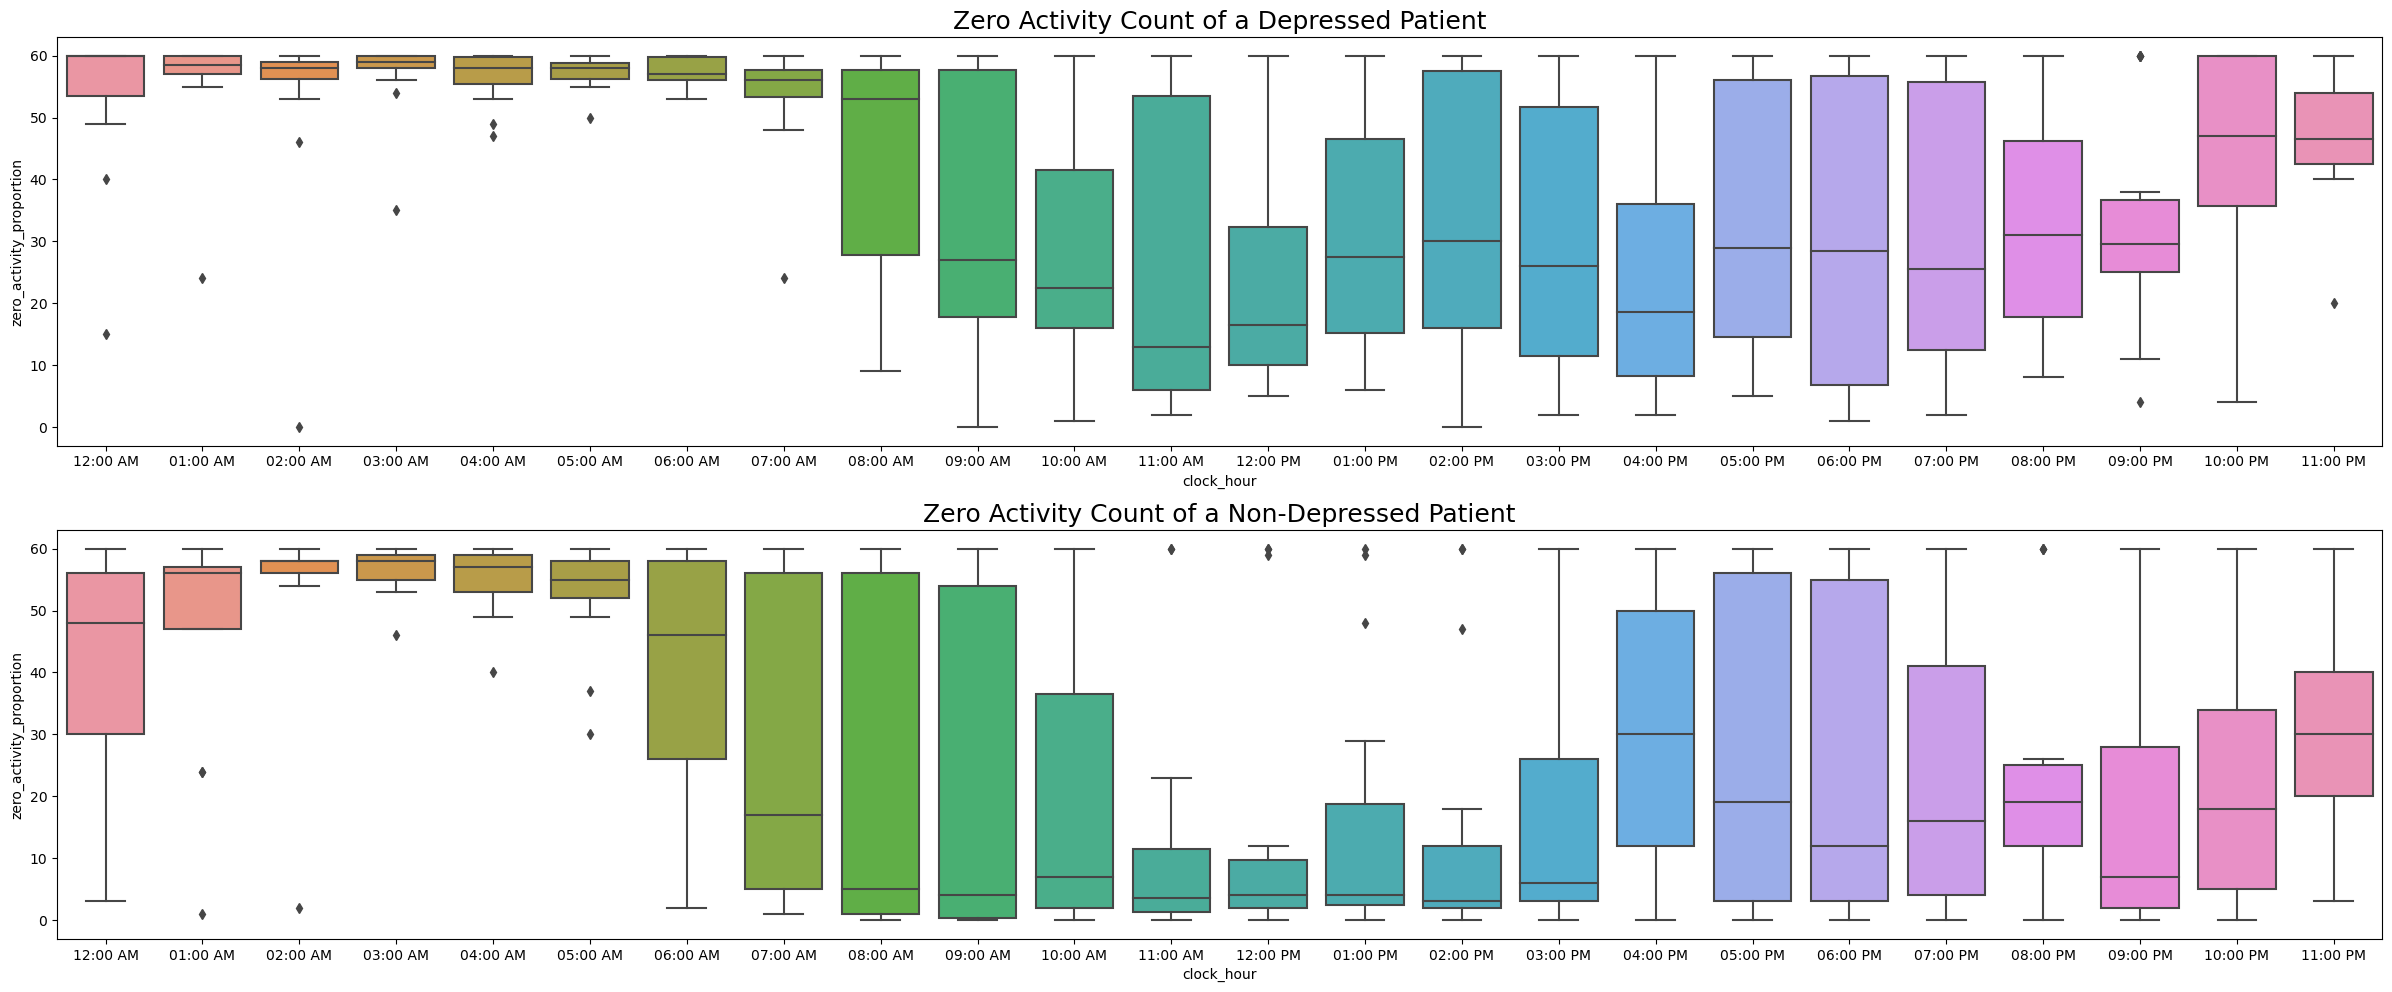

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(24, 10))
df = conditions[12].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[0])
axes[0].set_title('Zero Activity Count of a Depressed Patient', fontsize=18)

df = controls[2].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[1])
axes[1].set_title('Zero Activity Count of a Non-Depressed Patient', fontsize=18)

fig.tight_layout(pad=1.0)
plt.show()

In [9]:
def nextday(dates):
    for date in dates:
        yield date
# def zero_count(series):
#     return list(series).count(0)

In [10]:
def zero_count(series):
    return list(series).count(0)

In [11]:
def extractfeatures(X, date):
    mask = X['date'] == date
    d = {
        'mean_log_activity': X[mask]['log_activity'].mean(),
        'std_log_activity': X[mask]['log_activity'].std(),
        'min_log_activity': X[mask]['log_activity'].min(),
        'max_log_activity': X[mask]['log_activity'].max(),
        'zero_proportion_activity': zero_count(X[mask]['log_activity'])
    }
    return d

In [12]:
class ExtractData(BaseEstimator, TransformerMixin):
    
    def __init__(self, path):
        self.path = path
        self.X = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        dirs = os.listdir(self.path)
        
        for filepath in sorted(dirs, key=lambda x: x.split('_')[0]):
            condition = filepath.split('.')[0]
            if filepath.endswith('.csv'):
                X = pd.read_csv(self.path + filepath)
                X['log_activity'] = np.log(X['activity'] + 1)
                dates = X.date.unique()
                
                for date in nextday(dates):
                    d = extractfeatures(X, date)
                    d['source'] = condition
                    self.X.append(d)
                

        return pd.DataFrame(self.X)

In [35]:
e = ExtractData(path='C:/Users/User/Medical Datasets/depression/condition/')
conditions = e.fit_transform(X=None, y=None)
conditions['state'] = 1

In [36]:
conditions.tail()

mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
400           2.836361          2.604526               0.0          7.789869   
401           3.317860          2.664783               0.0          7.945201   
402           3.174113          2.653188               0.0          7.664816   
403           2.860525          2.617277               0.0          7.696213   
404           1.648750          2.476757               0.0          7.602900   

     zero_proportion_activity       source  state  
400                       578  condition_9      1  
401                       491  condition_9      1  
402                       505  condition_9      1  
403                       572  condition_9      1  
404                       596  condition_9      1

In [132]:
e = ExtractData(path='C:/Users/User/Medical Datasets/depression/control/')
controls = e.fit_transform(X=None, y=None)
controls['state'] = 0

In [133]:
control

mean_activity  std_activity  zero_activity_proportion  \
timestamp                                                                    
2003-11-11 09:00:00       7.033333      0.258199                         0   
2003-11-11 10:00:00      46.000000    116.759640                         0   
2003-11-11 11:00:00       5.000000      0.000000                         0   
2003-11-11 12:00:00       5.000000      0.000000                         0   
2003-11-11 13:00:00       5.783333      4.254974                         0   
...                            ...           ...                       ...   
2003-12-01 08:00:00      61.516667    188.260592                         0   
2003-12-01 09:00:00     134.116667    237.580394                         0   
2003-12-01 10:00:00      52.900000    108.865288                         0   
2003-12-01 11:00:00       5.000000      0.000000                         0   
2003-12-01 12:00:00       8.275862     13.368978                         0   

                        source  
timestamp                       
2003-11-11 09:00:00  control_9  
2003-11-11 10:00:00  control_9  
2003-11-11 11:00:00  control_9  
2003-11-11 12:00:00  control_9  
2003-11-11 13:00:00  control_9  
...                        ...  
2003-12-01 08:00:00  control_9  
2003-12-01 09:00:00  control_9  
2003-12-01 10:00:00  control_9  
2003-12-01 11:00:00  control_9  
2003-12-01 12:00:00  control_9  

[484 rows x 4 columns]

In [38]:
full_df = controls.append(conditions, ignore_index=True)
full_df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_408\2945302482.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = controls.append(conditions, ignore_index=True)


mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
0           4.269175          2.536873               0.0          7.758761   
1           3.006935          2.636401               0.0          8.038512   
2           3.220895          2.683718               0.0          7.883069   
3           2.737783          2.699849               0.0          7.633854   
4           3.302284          2.641430               0.0          7.789869   

   zero_proportion_activity     source  state  
0                       106  control_1      0  
1                       557  control_1      0  
2                       516  control_1      0  
3                       657  control_1      0  
4                       520  control_1      0

In [39]:
full_df = full_df.sample(frac=1) # reshufle the dataset

In [40]:
def custom_train_test_split(train_set, test_set):
    X_train = train_set.drop('label', axis=1)
    y_train = train_set.label
    X_test = test_set.drop('label', axis=1)
    y_test = test_set.label
    
    return X_train, X_test, y_train, y_test



In [92]:
class CustomClassifierCV(BaseEstimator, TransformerMixin):
    
    def __init__(self, base_clf):
        self.base_clf = base_clf
    
    def fit(self, X, y=None):
        X['label'] = y
        participants = X.source.unique()
        folds = []
        print(X.head)
        predictions = [] # predicted labels
        actuals = [] # actual labels
            
        for p in participants:
            folds.append(X[X['source'] == p])
        
        for i in range(len(folds)):   
            test_set = folds[i]
            train_fold = [elem for idx , elem in enumerate(folds) if idx != i]
            
            train_set = pd.concat(train_fold)
            X_train, X_test, y_train, y_test = custom_train_test_split(train_set.drop(['source'], axis=1),
                                    test_set.drop(['source'], axis=1))
            print(X_test.head())
            self.base_clf.fit(X_train, y_train)
            predictions.append(self.predict(X_test))
            actuals.append(test_set.label.iloc[0])
            
        self.score(predictions, actuals)
        
    def predict(self, X):
        predictions = self.base_clf.predict(X)
        ones = predictions.tolist().count(1)
        zeroes = predictions.tolist().count(0)
        
        return 1 if ones > zeroes else 0
    
    def score(self, predictions, actuals):
        print(classification_report(predictions, actuals))

In [93]:


X = full_df.drop(['state'], axis=1)
y = full_df.state



In [94]:


forest = RandomForestClassifier(n_estimators=100)
custom_clfCV = CustomClassifierCV(forest)
custom_clfCV.fit(X, y)


<bound method NDFrame.head of       mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
727            2.767870          2.472304          0.000000          7.891705   
694            0.578585          0.683852          0.000000          1.386294   
1107           4.049362          2.801417          0.000000          8.440744   
900            1.021113          2.083891          0.000000          8.069655   
1028           3.415804          2.849643          0.000000          7.852050   
...                 ...               ...               ...               ...   
752            2.383327          2.541136          0.000000          7.139660   
355            4.391975          2.809429          0.000000          7.914252   
803            0.314300          1.248602          0.000000          6.979145   
1106           3.109355          2.746481          0.000000          8.471987   
1049           4.575420          2.023319          1.386294          7.883069  

     mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
472           0.000000          0.000000               0.0          0.000000   
458           0.002080          0.055958               0.0          1.609438   
466           0.003369          0.075264               0.0          2.079442   
457           0.000963          0.036532               0.0          1.386294   
434           4.136139          2.660694               0.0          8.071219   

     zero_proportion_activity  
472                      1440  
458                      1438  
466                      1437  
457                      1439  
434                       379  
     mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
124           3.943099          2.727389               0.0          8.100768   
117           3.060960          2.734491               0.0          8.100768   
123           4.539336          2.455358               0.0          8.317278   
113    

     mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
777           1.441059          2.133564               0.0          7.257708   
774           2.422920          2.589224               0.0          7.509335   
776           3.252026          2.671832               0.0          7.633854   
783           3.287508          2.690459               0.0          7.758761   
778           1.360432          2.209044               0.0          7.540622   

     zero_proportion_activity  
777                       943  
774                       693  
776                       520  
783                       518  
778                       990  
    mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
8            2.636167          2.805051               0.0          8.069655   
10           2.857086          2.794388               0.0          7.789869   
29           0.616694          0.690055               0.0          2.197225   
25         

      mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
1071           2.524268          2.567830               0.0          7.972121   
1074           3.129791          2.459808               0.0          7.508239   
1069           3.475270          2.435285               0.0          7.662938   
1080           3.145590          2.666937               0.0          7.631917   
1076           3.660805          2.591160               0.0          8.435983   

      zero_proportion_activity  
1071                       651  
1074                       461  
1069                       382  
1080                       521  
1076                       395  
     mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
317           2.692973          2.375524               0.0          7.585281   
308           3.681127          2.459319               0.0          7.429521   
313           3.771351          2.496473               0.0          7.52294

     mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
207           3.179309          2.659476               0.0          7.512071   
201           3.506203          2.912103               0.0          7.916443   
215           1.856843          2.573317               0.0          7.387090   
209           2.906603          2.707947               0.0          7.636752   
205           3.516969          2.777424               0.0          7.418181   

     zero_proportion_activity  
207                       526  
201                       291  
215                       923  
209                       595  
205                       513  
    mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
43           3.895878          2.848252               0.0          8.353733   
46           3.530408          2.820178               0.0          7.889459   
51           2.388295          2.984807               0.0          8.353733   
38         

In [55]:

x = custom_clfCV
print(x)

CustomClassifierCV(base_clf=RandomForestClassifier())


In [56]:
import joblib

In [57]:
joblib.dump(x, "random_forest.joblib")

['random_forest.joblib']

In [60]:
loaded_rf = joblib.load("./random_forest.joblib")

In [89]:
X

mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
727            2.767870          2.472304          0.000000          7.891705   
694            0.578585          0.683852          0.000000          1.386294   
1107           4.049362          2.801417          0.000000          8.440744   
900            1.021113          2.083891          0.000000          8.069655   
1028           3.415804          2.849643          0.000000          7.852050   
...                 ...               ...               ...               ...   
752            2.383327          2.541136          0.000000          7.139660   
355            4.391975          2.809429          0.000000          7.914252   
803            0.314300          1.248602          0.000000          6.979145   
1106           3.109355          2.746481          0.000000          8.471987   
1049           4.575420          2.023319          1.386294          7.883069   

      zero_proportion_activity        source  label  
727                        450     control_9      0  
694                        839     control_7      0  
1107                       392   condition_7      1  
900                       1126  condition_17      1  
1028                       547  condition_23      1  
...                        ...           ...    ...  
752                        710   condition_1      1  
355                        383    control_26      0  
803                       1347  condition_12      1  
1106                       560   condition_7      1  
1049                         0   condition_3      1  

[1144 rows x 7 columns]

In [86]:
X_test = X.drop('label', axis=1)
X_test = X_test.drop('source', axis=1)

In [87]:
X_test

mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
727            2.767870          2.472304          0.000000          7.891705   
694            0.578585          0.683852          0.000000          1.386294   
1107           4.049362          2.801417          0.000000          8.440744   
900            1.021113          2.083891          0.000000          8.069655   
1028           3.415804          2.849643          0.000000          7.852050   
...                 ...               ...               ...               ...   
752            2.383327          2.541136          0.000000          7.139660   
355            4.391975          2.809429          0.000000          7.914252   
803            0.314300          1.248602          0.000000          6.979145   
1106           3.109355          2.746481          0.000000          8.471987   
1049           4.575420          2.023319          1.386294          7.883069   

      zero_proportion_activity  
727                        450  
694                        839  
1107                       392  
900                       1126  
1028                       547  
...                        ...  
752                        710  
355                        383  
803                       1347  
1106                       560  
1049                         0  

[1144 rows x 5 columns]

In [88]:
loaded_rf.predict(X_test)

0

In [4]:
trial =pd.read_csv('C:/Users/User/Medical Datasets/depression/condition/condition_1.csv')
trial.tail()

timestamp        date  activity
23239  2003-05-23 15:19:00  2003-05-23         0
23240  2003-05-23 15:20:00  2003-05-23         0
23241  2003-05-23 15:21:00  2003-05-23         0
23242  2003-05-23 15:22:00  2003-05-23         0
23243  2003-05-23 15:23:00  2003-05-23       533

In [5]:
# def extractfeatures(X, date):
#     mask = X['date'] == date
#     d = {
#         'mean_log_activity': X[mask]['log_activity'].mean(),
#         'std_log_activity': X[mask]['log_activity'].std(),
#         'min_log_activity': X[mask]['log_activity'].min(),
#         'max_log_activity': X[mask]['log_activity'].max(),
#         'zero_proportion_activity': zero_count(X[mask]['log_activity'])
#     }
#     print(d)
#     return d

In [6]:
# def nextday(dates):
#     for date in dates:
#         yield date
# def zero_count(series):
#     return list(series).count(0)

In [7]:
# X_test1 = []
# trial['log_activity'] = np.log(trial['activity'] + 1)
# dates = trial.date.unique()
# for date in nextday(dates):
#     d = extractfeatures(trial, date)
#     #d['source'] = condition
#     #X_test1.append(d)
#     t = pd.DataFrame(X_test1)
#     #t.fit_transform(X=None, y=None)

In [18]:
e = ExtractData(path='C:/Users/User/temp/')
temp = e.fit_transform(X=None, y=None)
temp['state'] = 0

In [19]:
temp

mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
0            4.110061          2.274294          0.000000          8.100768   
1            4.407098          2.834101          0.000000          8.317278   
2            3.807329          2.890828          0.000000          8.069655   
3            4.500148          2.680496          0.000000          8.193400   
4            3.339173          2.823053          0.000000          8.348064   
5            3.060960          2.734491          0.000000          8.100768   
6            4.132200          2.744903          0.000000          8.688117   
7            3.344571          2.773001          0.000000          8.162516   
8            4.285063          2.625557          0.000000          8.100768   
9            3.168678          2.833937          0.000000          7.976595   
10           3.524877          2.927836          0.000000          8.162516   
11           4.539336          2.455358          0.000000          8.317278   
12           3.943099          2.727389          0.000000          8.100768   
13           3.257322          3.072587          0.000000          8.224164   
14           1.991181          1.965560          0.000000          7.976595   
15           2.011851          1.021779          1.386294          7.100852   

    zero_proportion_activity       source  state  
0                         38  251_mentalh      0  
1                        353  251_mentalh      0  
2                        456  251_mentalh      0  
3                        312  251_mentalh      0  
4                        477  251_mentalh      0  
5                        549  251_mentalh      0  
6                        326  251_mentalh      0  
7                        465  251_mentalh      0  
8                        314  251_mentalh      0  
9                        506  251_mentalh      0  
10                       497  251_mentalh      0  
11                       211  251_mentalh      0  
12                       371  251_mentalh      0  
13                       575  251_mentalh      0  
14                       379  251_mentalh      0  
15                         0  251_mentalh      0

In [145]:
temp = temp.drop('source', axis=1)
temp = temp.drop('state', axis=1)

In [146]:
temp

mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
0            5.110954          1.875912               0.0          7.696213   
1            3.835874          2.660859               0.0          7.664816   
2            4.347506          2.851807               0.0          8.131531   
3            3.914182          3.018889               0.0          8.038512   
4            2.911614          2.871559               0.0          7.883069   
5            4.041497          2.902987               0.0          7.976595   
6            4.155466          3.148177               0.0          8.131531   
7            3.564578          2.959083               0.0          8.131531   
8            3.905997          3.121659               0.0          8.255309   
9            3.845487          3.021576               0.0          7.976595   
10           3.287246          2.988565               0.0          8.038512   
11           3.596577          2.830906               0.0          7.821242   
12           3.931254          2.875792               0.0          7.945201   
13           3.576329          2.888037               0.0          8.038512   
14           3.592627          2.973595               0.0          7.852050   
15           4.116227          2.746243               0.0          8.007367   
16           4.445748          2.825073               0.0          8.255309   
17           4.685789          2.840214               0.0          8.502689   
18           4.502642          3.003804               0.0          7.945201   
19           4.808455          2.904299               0.0          8.317278   
20           4.308669          2.958480               0.0          8.131531   
21           0.700422          1.814800               0.0          7.696213   
22           0.178370          0.941293               0.0          7.446001   

    zero_proportion_activity  
0                         39  
1                        425  
2                        397  
3                        488  
4                        657  
5                        449  
6                        480  
7                        533  
8                        524  
9                        513  
10                       603  
11                       492  
12                       456  
13                       533  
14                       545  
15                       398  
16                       373  
17                       348  
18                       406  
19                       353  
20                       421  
21                      1225  
22                       666

In [147]:
loaded_rf.predict(temp)

0